# Hidden Markov Model Experiments

## 1. Initialization of Environment

In [1]:
# Experiment with barcrawl data
import numpy as np
from hmmlearn import hmm
from hmmlearn import vhmm
from data_combined_reader import load_combined_data
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from scipy.special import softmax
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold  # Cross-validation tools
import sklearn_crfsuite
from imblearn.over_sampling import SMOTE
from copy import deepcopy

# Data windowing settings (this is actually read from PKL data files,
# but we provide a default here)
DEFAULT_WINDOW = 400  # 10 second window: 10 seconds * 40Hz = 400 samples per window

window = DEFAULT_WINDOW

TEST_RATIO = 0.30

## 2. Choose PIDs to Process

In [2]:
PIDS = [
    "BK7610",
    "BU4707",
    "CC6740",
    "DC6359",
    "DK3500",
    "HV0618",
    "JB3156",
    "JR8022",
    "MC7070",
    "MJ8002",
    "PC6771",
    "SA0297",
    "SF3079",
]

## 3. Load Data

In [3]:
from scipy.signal import butter, filtfilt

# Apply butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    y = filtfilt(b, a, data, padlen=len(data) - 1)
    return y

window, train_data_set, test_data_set = load_combined_data(PIDS, TEST_RATIO, True)
Xtr, _, Ytr = zip(*train_data_set)
Xva, _, Yva = zip(*test_data_set)
sequence_length = Xtr[0].shape[0]

#Strip timestamps
Xtr = np.array([x[:, 1:] for x in Xtr])
Xva = np.array([x[:, 1:] for x in Xva])

#Low pass filter
# SAMPLE_RATE = 40  # Hz
# FREQ_CUTOFF = 1  # Hz
# Xtr[:, :, 0] = np.array([butter_lowpass_filter(x[:, 0], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xtr[:, :, 1] = np.array([butter_lowpass_filter(x[:, 1], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xtr[:, :, 2] = np.array([butter_lowpass_filter(x[:, 2], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xtr])
# Xva[:, :, 0] = np.array([butter_lowpass_filter(x[:, 0], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])
# Xva[:, :, 1] = np.array([butter_lowpass_filter(x[:, 1], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])
# Xva[:, :, 2] = np.array([butter_lowpass_filter(x[:, 2], FREQ_CUTOFF, SAMPLE_RATE, 3) for x in Xva])


Reading in all data
Shuffle window data?: True
Shuffling windows randomly
Number of Windows for Training: 92689
Number of Windows for Testing: 39736


In [4]:
def print_metrics(y_true, y_preds):
    c_matrix = confusion_matrix(y_true, y_preds)
    t_pos = c_matrix[1][1]
    t_neg = c_matrix[0][0]
    f_pos = c_matrix[0][1]
    f_neg = c_matrix[1][0]

    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    acc = accuracy_score(y_true, y_preds)
    b_acc = balanced_accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    sober_data = [d for d in list(zip(y_true, y_preds)) if d[0] == 0]
    sober_true = np.array([d[0] for d in sober_data])
    sober_pred = np.array([d[1] for d in sober_data])
    sober_acc = accuracy_score(sober_true, sober_pred)

    drunk_data = [d for d in list(zip(y_true, y_preds)) if d[0] == 1]
    drunk_true = np.array([d[0] for d in drunk_data])
    drunk_pred = np.array([d[1] for d in drunk_data])
    drunk_acc = accuracy_score(drunk_true, drunk_pred)

    print("Accuracy = %f" % acc)
    print("Precision = %f" % precision)
    print("Recall = %f" % recall)
    print("F1-score = %f" % f1)
    print("Balanced Accuracy = %f" % b_acc)
    print("Sober Accuracy = %f" % sober_acc)
    print("Drunk Accuracy = %f" % drunk_acc)
    print("False negatives = %d" % f_neg)
    print("False postives = %d" % f_pos)
    print("True negatives = %d" % t_neg)
    print("True positives = %d" % t_pos)

    fig, ax = plt.subplots(figsize=(5, 5))
    metrics.RocCurveDisplay.from_predictions(
        y_true,
        y_preds,
        name=f"ROC curve",
        ax=ax,
    )

    plt.axis("square")
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    # plt.title("ROC Curves for Shuffled Data")
    plt.legend()


## 3.5 Check Bayesian Information Criterion to find best number of hidden states

Answer was 2; >2 took exponentially longer and are not feasible for deployment

In [5]:
# Determine the optimal number of components using BIC
# bic_scores = []
# aic_scores = []
# num_components_range = range(1, 3)  # Test from 1 to 2
# X_train_reshaped = Xtr.reshape(-1, 3)
# lengths = [sequence_length] * Xtr.shape[0]

# for n_components in num_components_range:
#     print("Checking n_components = %d" % n_components)
#     model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100)
#     model.fit(X_train_reshaped, lengths)
    
#     bic_scores.append(model.bic(X_train_reshaped, lengths))
#     aic_scores.append(model.aic(X_train_reshaped, lengths))

# optimal_components = num_components_range[np.argmin(bic_scores)]
# print(f"Optimal number of components (BIC): {optimal_components}")

## 4. Similarity based HMM Classifier Approach

In [5]:
class SimilarityHMMClassifier():
    def __init__(self, class_num: int, model : hmm.BaseHMM, sim_model : object):
        self.models = {}
        self.base_model = model
        self.sim_model = sim_model
        self.class_num = class_num

    def converged(self):
        return all(self.models[c].monitor_.converged == True for c in range(self.class_num))   

    def fit(self, X : np.ndarray, Y : np.ndarray):
        """
        Arguments follow convention for sklearn classifiers
        """
        # Fit HMMs
        print("Fit HMMs")
        x_windows = {c: [] for c in range(self.class_num)}
        x_lengths = {c: [] for c in range(self.class_num)}
        
        for x, y in zip(X, Y):
            x_windows[y].extend(x)
            x_lengths[y].append(x.shape[0])
        for c in range(self.class_num):
            hmm_model = deepcopy(self.base_model)
            hmm_model.fit(x_windows[c], x_lengths[c])
            self.models[c] = hmm_model

        # Fit similarity classifier
        print("Fit similarity classifier")
        X_f = np.concatenate([self._seq_class_similarities(x) for x in X], axis=0)
        self.sim_model.fit(X_f, Y)

    def _seq_class_similarities(self, seq : np.ndarray):
        feature_vec = np.zeros((1, self.class_num))
        seq_len = [seq.shape[0]]
        for c in range(self.class_num):
            feature_vec[:, c] = self.models[c].score(seq, seq_len)
        feature_vec /= seq_len

        return feature_vec

    def predict_proba(self, X : np.ndarray):
        """
        Arguments follow convention for sklearn classifiers
        """
        X_f = np.concatenate([self._seq_class_similarities(x) for x in X], axis=0)
        prob = self.sim_model.predict_proba(X_f)
        return prob
    
    def predict(self, X : np.ndarray):
        """
        Arguments follow convention for sklearn classifiers
        """
        X_f = np.concatenate([self._seq_class_similarities(x) for x in X], axis=0)
        pred = self.sim_model.predict(X_f)

        return pred

## 5. Try out Similarity-based HMM Classifier with Nearest-Neighbor

Begin training
Converged?:  True
Begin Prediction for Training data
Accuracy = 0.919980
Precision = 0.842312
Recall = 0.865387
F1-score = 0.853694
Balanced Accuracy = 0.902768
Sober Accuracy = 0.940148
Drunk Accuracy = 0.865387
False negatives = 3366
False postives = 4051
True negatives = 63633
True positives = 21639
Begin Prediction for Test data
Accuracy = 0.804233
Precision = 0.637948
Recall = 0.652021
F1-score = 0.644908
Balanced Accuracy = 0.756656
Sober Accuracy = 0.861290
Drunk Accuracy = 0.652021
False negatives = 3770
False postives = 4009
True negatives = 24893
True positives = 7064


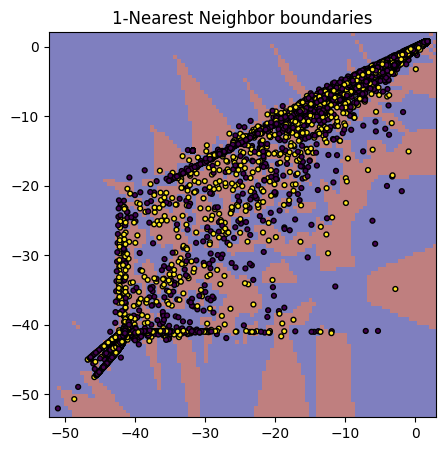

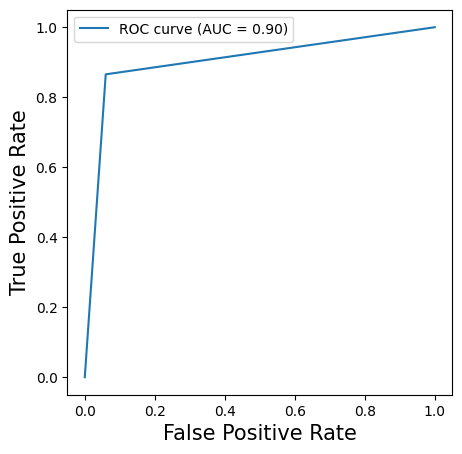

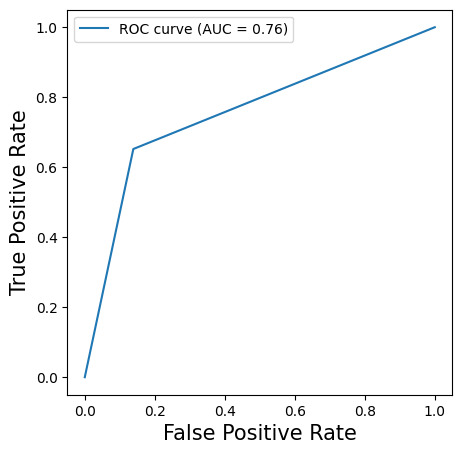

In [25]:
base_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
sim_model = KNeighborsClassifier(n_neighbors=1)
model = SimilarityHMMClassifier(class_num=2, model=base_model, sim_model=sim_model)
print("Begin training")
model.fit(Xtr, Ytr)
print("Converged?: ", model.converged())

Xtr_f = np.concatenate([model._seq_class_similarities(x) for x in Xtr], axis=0)

# Create a figure
figure, axes = plt.subplots(1, 1, figsize=(5, 5))

plot_kwargs = {
    "cmap": "jet",  # also: viridis
    "response_method": "predict",
    "plot_method": "pcolormesh",
    "shading": "auto",
    "alpha": 0.5,
    "grid_resolution": 100,
}

# Plot the resulting decision boundary for knn
DecisionBoundaryDisplay.from_estimator(model.sim_model, Xtr_f, ax=axes, **plot_kwargs)

# Scatter plot of the training data
axes.scatter(Xtr_f[:, 0], Xtr_f[:, 1], c=Ytr, edgecolor="k", s=12)
#axes.scatter(Xva_f[:, 0], Xva_f[:, 1], c=Yva, edgecolor="c", s=12)
axes.set_title(f"1-Nearest Neighbor boundaries")

print("Begin Prediction for Training data")
y_pred = model.predict(Xtr)
print_metrics(Ytr, y_pred)

print("Begin Prediction for Test data")
y_pred = model.predict(Xva)
print_metrics(Yva, y_pred)


## 6. Similarity HMM Classifier with Random Forest

Begin training
Fit HMMs
Fit similarity classifier
Converged?:  True
Begin Prediction for Training data
Accuracy = 0.882985
Precision = 0.883595
Recall = 0.655910
F1-score = 0.752916
Balanced Accuracy = 0.811828
Sober Accuracy = 0.967746
Drunk Accuracy = 0.655910
False negatives = 8669
False postives = 2177
True negatives = 65318
True positives = 16525
Begin Prediction for Test data
Accuracy = 0.847871
Precision = 0.790845
Recall = 0.587506
F1-score = 0.674177
Balanced Accuracy = 0.765325
Sober Accuracy = 0.943144
Drunk Accuracy = 0.587506
False negatives = 4391
False postives = 1654
True negatives = 27437
True positives = 6254


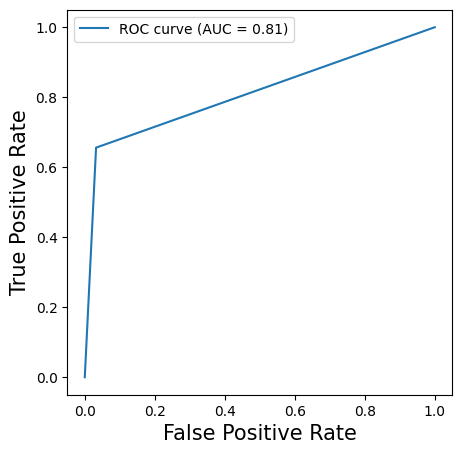

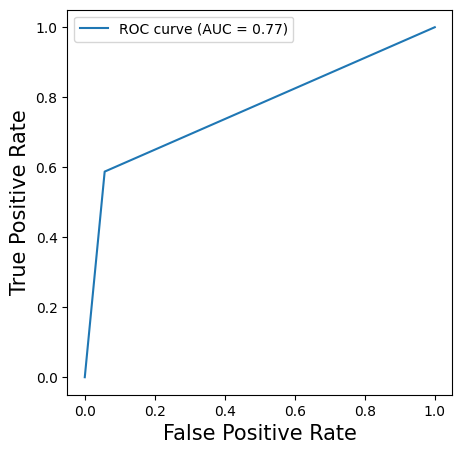

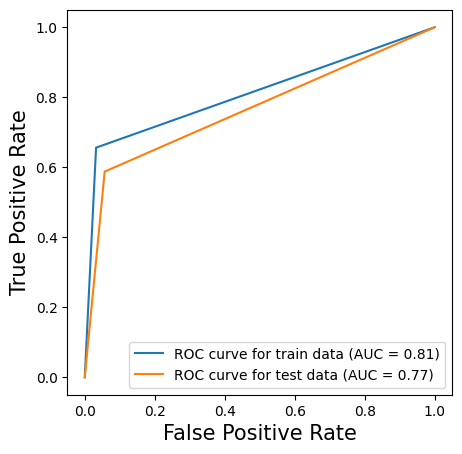

In [6]:
base_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
sim_model = RandomForestClassifier(random_state=1234, max_depth=15, n_jobs=-1, oob_score=True)
model = SimilarityHMMClassifier(class_num=2, model=base_model, sim_model=sim_model)
print("Begin training")
model.fit(Xtr, Ytr)
print("Converged?: ", model.converged())

print("Begin Prediction for Training data")
y_pred1 = model.predict(Xtr)
print_metrics(Ytr, y_pred1)

print("Begin Prediction for Test data")
y_pred2 = model.predict(Xva)
print_metrics(Yva, y_pred2)


fig, ax = plt.subplots(figsize=(5, 5))
metrics.RocCurveDisplay.from_predictions(
    Ytr,
    y_pred1,
    name=f"ROC curve for train data",
    ax=ax,
)
metrics.RocCurveDisplay.from_predictions(
    Yva,
    y_pred2,
    name=f"ROC curve for test data",
    ax=ax,
)

plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
# plt.title("ROC Curves for Shuffled Data")
plt.legend()